# Correlated Logistic Growth Experiment


## Refactored Experiment

Create a class, where each instance of the class represents some node/location. Each node is related by the geographic distance between them. 

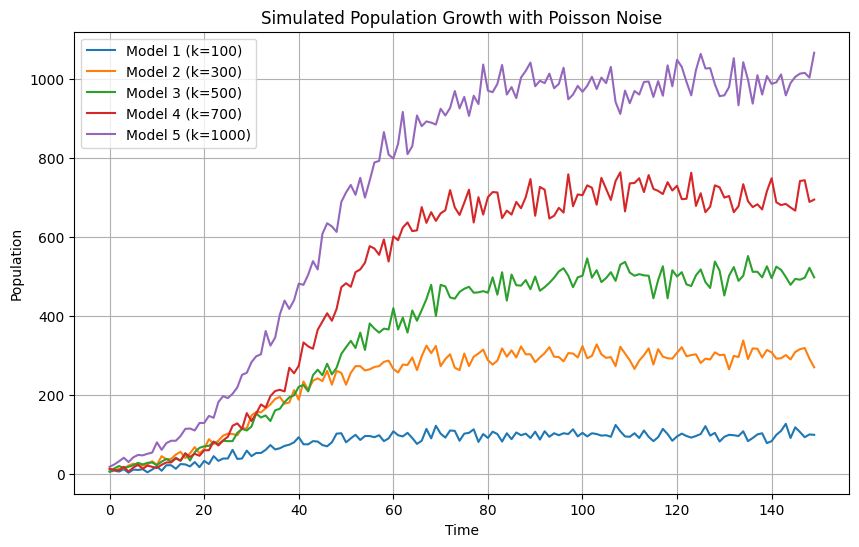

In [40]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm
import stan 
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax
import jax.numpy as jnp
from jax import random


num_nodes = 5
time_steps = 150
states = np.array([5, 12, 15, 8, 27])
carrying_capacities = np.array([100, 300, 500, 700, 1000])
distances = np.array([
    [0, 2, 5, 10, 15],
    [2, 0, 3, 8, 13],
    [5, 3, 0, 5, 10],
    [10, 8, 5, 0, 5],
    [15, 13, 10, 5, 0]
])


def covariance_function(dist, sigma, rho):
    '''Exponential decay of variance based on distance.'''
    return sigma**2 * np.exp(-dist / rho)


class Node:
    '''Represents some location/population.'''
    def __init__(self, initial_state, carrying_capacity, growth_rate):
        self.initial_state = initial_state
        self.carrying_capacity = carrying_capacity
        self.growth_rate = growth_rate

    def logistic_growth(self, t, y):
        return self.growth_rate * y * (1 - (y / self.carrying_capacity))
    

# Parameters
mean_r = 0.1
sigma = 0.02
corr_coeff = 0.5
rho = 5

# Compute the covariance matrix based on distances
cov_matrix = np.zeros((num_nodes, num_nodes))
for i in range(num_nodes):
    for j in range(num_nodes):
        cov_matrix[i, j] = covariance_function(distances[i, j], sigma, rho)

# Generate correlated growth rates
r_values = np.random.multivariate_normal(np.full(num_nodes, mean_r), cov_matrix)
for r in r_values:
    if r < 0:
        r = 0.01

nodes = [Node(states[i], carrying_capacities[i], r_values[i]) for i in range(num_nodes)]
generated_data = np.empty([num_nodes, time_steps])

for i, node in enumerate(nodes):
    sol = solve_ivp(fun=node.logistic_growth, t_span=[0, time_steps], y0=[node.initial_state], t_eval=range(time_steps))
    generated_data[i] = np.random.poisson(sol.y[0])


# Save to CSV
file_path = './experiment_time_series.csv'
df = pd.DataFrame(generated_data.T, columns=[f'Model {i+1} (k={k})' for i, k in enumerate(carrying_capacities)])
df.to_csv(file_path, index=False)

# Create plot for generated_data 
plt.figure(figsize=(10, 6))
for i in range(num_nodes):
    plt.plot(np.arange(time_steps), generated_data[i], label=f'Model {i+1} (k={carrying_capacities[i]})')

plt.title('Simulated Population Growth with Poisson Noise')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

## Inference

We will use a simple particle filter to infer `r` values from the population data at each time point. 

The Cholesky decomposition matrix ensures that the process noise for `r` values respects the correlation between nodes. 

### 100 Particles

In [41]:
from scipy.stats import poisson

num_particles = 100
initial_states = np.array([5, 12, 15, 8, 27])

# Define Q, the covariance matrix for r-values based on distance.
# L is the Cholesky decomposition matrix.
Q = cov_matrix
L = np.linalg.cholesky(Q)

# Initialize particles (each particle includes both population levels and r values)
particles = np.hstack((
    # Initial state for each particle are centered around the actual intiial_states, with no covariance.
    np.random.multivariate_normal(mean=initial_states, cov=np.diag([1.0]*num_nodes), size=num_particles),
    
    # Initial r values are centered around the true mean r, with covariance based on distance.
    np.random.multivariate_normal(mean=np.full(num_nodes, 0.1), cov=Q, size=num_particles)
))
weights = np.ones(num_particles) / num_particles

def state_transition(state, k, L):
    """
    Propagates a particle's state forward by one time step. 

    Args:
        state (Array[float]): A particle's state vector.
        k (Array[int]): Carrying capacities for each node
        L (matrix): Cholesky decomposition matrix

    Returns:
        np.hstack: Propagated particle cloud.
    """    
    population = state[:num_nodes] # first half of a particle's state vector
    r = state[num_nodes:] # second half of a particle's state vector

    process_noise_population = np.random.normal(0, 0.1, num_nodes) 

    # Multiply by a scalar to dampen the process noise for r. 
    process_noise_r = L @ np.random.randn(num_nodes) * 0.2

    new_population = population + r * population * (1 - population / k) + process_noise_population
    new_population = np.clip(new_population, 1, k)  # ensure new pop. is within [1,k]
    new_r = np.clip(r + process_noise_r, 0, None) # Ensure r is non-negative

    return np.hstack((new_population, new_r))


def observation_likelihood(observation, predicted_state):
    """
    Computes the likelihood of observing a data point, given a particle's predicted state.

    Args:
        observation (Array[float]): A data point containing the population of each node at time t.
        predicted_state (Array[float]): A particle's predicted state vector.

    Returns:
        float: Likelihood of the observation.
    """    
    predicted_population = predicted_state[:num_nodes]
    likelihood = poisson.pmf(observation, predicted_population)
    
    return np.prod(likelihood + 1e-10)  # Add a small constant to avoid zeros.


# Store estimated populations at each time step for plotting.
estimated_populations = np.zeros((num_nodes, time_steps))

# Particle filter loop
for t in range(1, time_steps):
    # Prediction step
    particles = np.array([state_transition(p, carrying_capacities, L) for p in particles])

    # Update step
    weights = np.array([observation_likelihood(generated_data[:, t], p) for p in particles])
    weights += 1e-10 # Regularize weights to avoid zeros
    weights /= np.sum(weights)  # Normalize weights

    # Resampling step
    indices = np.random.choice(np.arange(num_particles), size=num_particles, p=weights)
    particles = particles[indices]
    weights = np.ones(num_particles) / num_particles  # Reset weights after resampling

    # Store the estimated population at the current time step
    estimated_populations[:, t] = np.average(particles[:, :num_nodes], axis=0, weights=weights)

# Final state estimate (average over particles)
estimated_population = np.average(particles[:, :num_nodes], axis=0, weights=weights)
estimated_r_values = np.average(particles[:, num_nodes:], axis=0, weights=weights)
print("Estimated population:", estimated_population)
print("True Population:", generated_data[:, time_steps-1])
print("Estimated r values:", estimated_r_values)
print("True r values:", r_values)


Estimated population: [ 99.85091216 299.84124607 499.6989298  699.87658603 999.72131169]
True Population: [  99.  270.  498.  695. 1067.]
Estimated r values: [0.08277628 0.10109231 0.07042903 0.11305595 0.07234386]
True r values: [0.10621666 0.10093792 0.07801714 0.10338135 0.08672836]


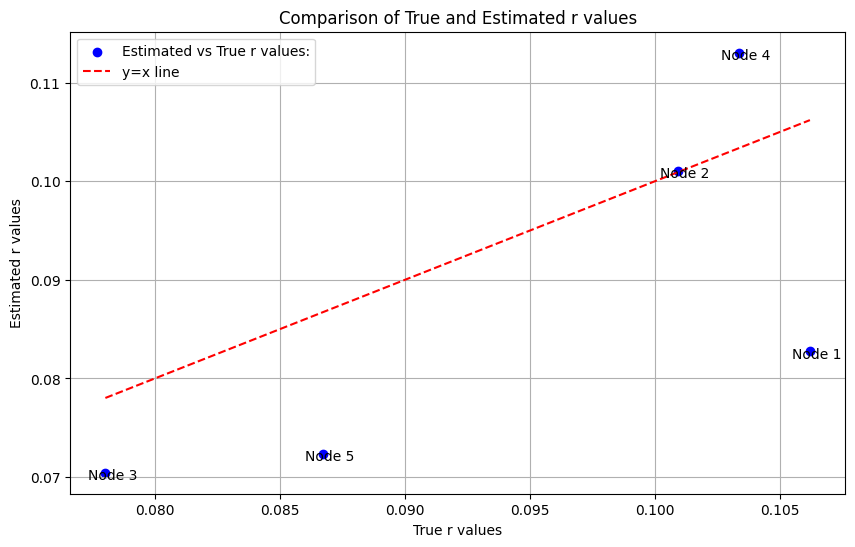

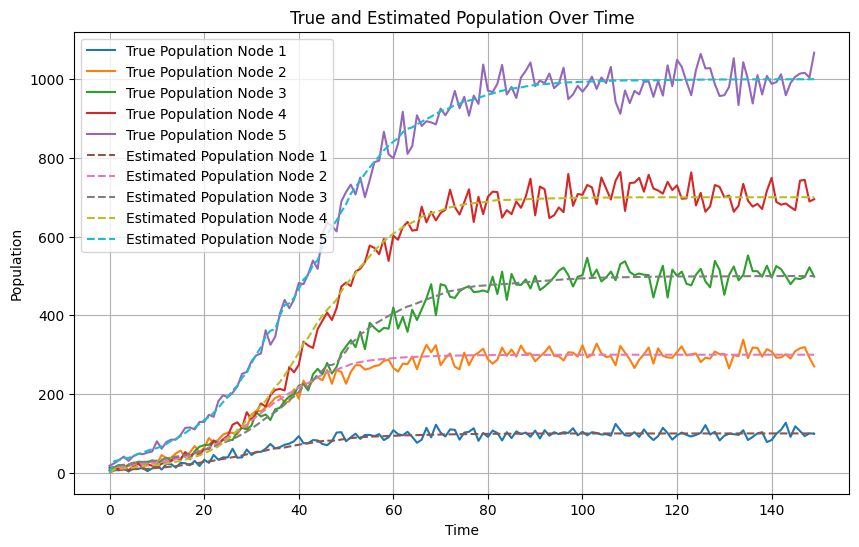

In [42]:
node_labels = [f'Node {i+1}' for i in range(len(r_values))]

"""Plotting r values"""
plt.figure(figsize=(10, 6))
plt.scatter(r_values, estimated_r_values, c='blue', label='Estimated vs True r values:')

# Add labels to each point
for i, label in enumerate(node_labels):
    plt.annotate(label, (r_values[i], estimated_r_values[i]), textcoords="offset points", xytext=(5,-5), ha='center')

# Plot the y=x reference line
plt.plot([min(r_values), max(r_values)], [min(r_values), max(r_values)], 'r--', label='y=x line')

# Add labels and title
plt.xlabel('True r values')
plt.ylabel('Estimated r values')
plt.title('Comparison of True and Estimated r values')
plt.legend()
plt.grid(True)
plt.show()


"""Plotting population"""
time_steps = generated_data.shape[1]
num_nodes = generated_data.shape[0]

# Plot the true population over time
plt.figure(figsize=(10, 6))
for i in range(num_nodes):
    plt.plot(range(time_steps), generated_data[i], label=f'True Population Node {i+1}')

# Plot the estimated population over time

for i in range(num_nodes):
    plt.plot(range(time_steps), estimated_populations[i], linestyle='--', label=f'Estimated Population Node {i+1}')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('True and Estimated Population Over Time')
plt.legend()
plt.grid(True)
plt.show()

### 1000 Particles

In [48]:
from scipy.stats import poisson

num_particles = 1000
initial_states = np.array([5, 12, 15, 8, 27])

# Define Q, the covariance matrix for r-values based on distance.
# L is the Cholesky decomposition matrix.
Q = cov_matrix
L = np.linalg.cholesky(Q)

# Initialize particles (each particle includes both population levels and r values)
particles = np.hstack((
    # Initial state for each particle are centered around the actual intiial_states, with no covariance.
    np.random.multivariate_normal(mean=initial_states, cov=np.diag([1.0]*num_nodes), size=num_particles),
    
    # Initial r values are centered around the true mean r, with covariance based on distance.
    np.random.multivariate_normal(mean=np.full(num_nodes, 0.1), cov=Q, size=num_particles)
))
weights = np.ones(num_particles) / num_particles

def state_transition(state, k, L):
    """
    Propagates a particle's state forward by one time step. 

    Args:
        state (Array[float]): A particle's state vector.
        k (Array[int]): Carrying capacities for each node
        L (matrix): Cholesky decomposition matrix

    Returns:
        np.hstack: Propagated particle cloud.
    """    
    population = state[:num_nodes] # first half of a particle's state vector
    r = state[num_nodes:] # second half of a particle's state vector

    process_noise_population = np.random.normal(0, 0.1, num_nodes) 

    # Multiply by a scalar to dampen the process noise for r. 
    process_noise_r = L @ np.random.randn(num_nodes) * 0.2

    new_population = population + r * population * (1 - population / k) + process_noise_population
    new_population = np.clip(new_population, 1, k)  # ensure new pop. is within [1,k]
    new_r = np.clip(r + process_noise_r, 0, None) # Ensure r is non-negative

    return np.hstack((new_population, new_r))


def observation_likelihood(observation, predicted_state):
    """
    Computes the likelihood of observing a data point, given a particle's predicted state.

    Args:
        observation (Array[float]): A data point containing the population of each node at time t.
        predicted_state (Array[float]): A particle's predicted state vector.

    Returns:
        float: Likelihood of the observation.
    """    
    predicted_population = predicted_state[:num_nodes]
    likelihood = poisson.pmf(observation, predicted_population)
    
    return np.prod(likelihood + 1e-10)  # Add a small constant to avoid zeros.


# Store estimated populations at each time step for plotting.
estimated_populations = np.zeros((num_nodes, time_steps))

# Particle filter loop
for t in range(1, time_steps):
    # Prediction step
    particles = np.array([state_transition(p, carrying_capacities, L) for p in particles])

    # Update step
    weights = np.array([observation_likelihood(generated_data[:, t], p) for p in particles])
    weights += 1e-10 # Regularize weights to avoid zeros
    weights /= np.sum(weights)  # Normalize weights

    # Resampling step
    indices = np.random.choice(np.arange(num_particles), size=num_particles, p=weights)
    particles = particles[indices]
    weights = np.ones(num_particles) / num_particles  # Reset weights after resampling

    # Store the estimated population at the current time step
    estimated_populations[:, t] = np.average(particles[:, :num_nodes], axis=0, weights=weights)

# Final state estimate (average over particles)
estimated_population = np.average(particles[:, :num_nodes], axis=0, weights=weights)
estimated_r_values = np.average(particles[:, num_nodes:], axis=0, weights=weights)
print("Estimated population:", estimated_population)
print("True Population:", generated_data[:, time_steps-1])
print("Estimated r values:", estimated_r_values)
print("True r values:", r_values)


Estimated population: [ 99.80826685 299.83035632 499.82472466 699.86295001 999.42587417]
True Population: [  99.  270.  498.  695. 1067.]
Estimated r values: [0.08720834 0.09611322 0.09838215 0.1164797  0.07562891]
True r values: [0.10621666 0.10093792 0.07801714 0.10338135 0.08672836]


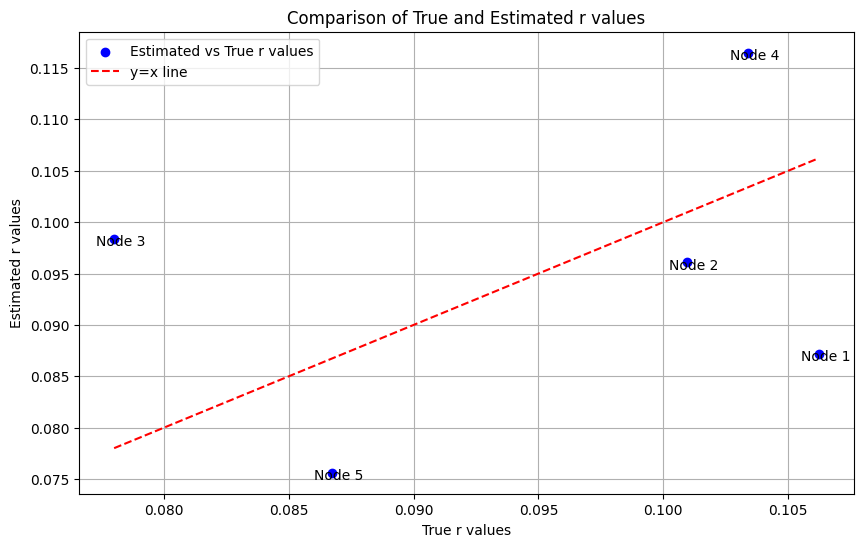

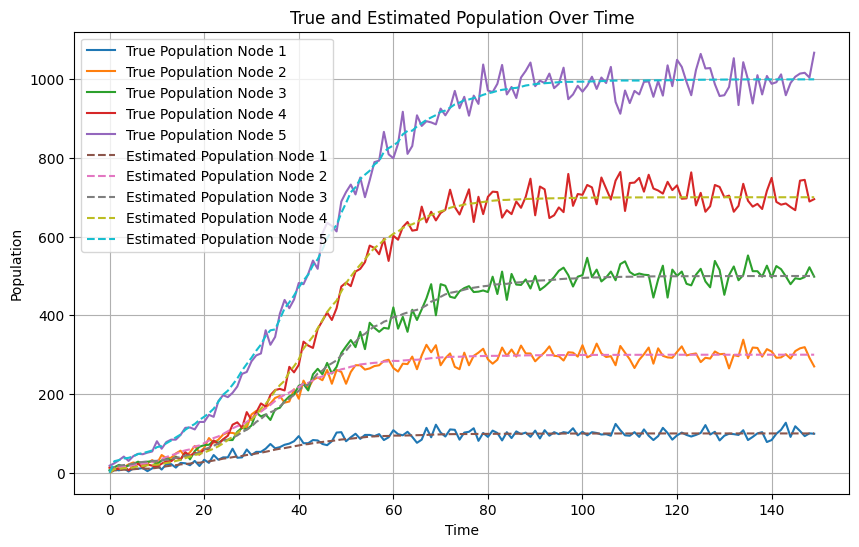

In [49]:
node_labels = [f'Node {i+1}' for i in range(len(r_values))]

"""Plotting r values"""
plt.figure(figsize=(10, 6))
plt.scatter(r_values, estimated_r_values, c='blue', label='Estimated vs True r values')

# Add labels to each point
for i, label in enumerate(node_labels):
    plt.annotate(label, (r_values[i], estimated_r_values[i]), textcoords="offset points", xytext=(5,-5), ha='center')

# Plot the y=x reference line
plt.plot([min(r_values), max(r_values)], [min(r_values), max(r_values)], 'r--', label='y=x line')

# Add labels and title
plt.xlabel('True r values')
plt.ylabel('Estimated r values')
plt.title('Comparison of True and Estimated r values')
plt.legend()
plt.grid(True)
plt.show()


"""Plotting population"""
time_steps = generated_data.shape[1]
num_nodes = generated_data.shape[0]

# Plot the true population over time
plt.figure(figsize=(10, 6))
for i in range(num_nodes):
    plt.plot(range(time_steps), generated_data[i], label=f'True Population Node {i+1}')

# Plot the estimated population over time

for i in range(num_nodes):
    plt.plot(range(time_steps), estimated_populations[i], linestyle='--', label=f'Estimated Population Node {i+1}')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('True and Estimated Population Over Time')
plt.legend()
plt.grid(True)
plt.show()

### 5 Particles

In [50]:
from scipy.stats import poisson

num_particles = 5
initial_states = np.array([5, 12, 15, 8, 27])

# Define Q, the covariance matrix for r-values based on distance.
# L is the Cholesky decomposition matrix.
Q = cov_matrix
L = np.linalg.cholesky(Q)

# Initialize particles (each particle includes both population levels and r values)
particles = np.hstack((
    # Initial state for each particle are centered around the actual intiial_states, with no covariance.
    np.random.multivariate_normal(mean=initial_states, cov=np.diag([1.0]*num_nodes), size=num_particles),
    
    # Initial r values are centered around the true mean r, with covariance based on distance.
    np.random.multivariate_normal(mean=np.full(num_nodes, 0.1), cov=Q, size=num_particles)
))
weights = np.ones(num_particles) / num_particles

def state_transition(state, k, L):
    """
    Propagates a particle's state forward by one time step. 

    Args:
        state (Array[float]): A particle's state vector.
        k (Array[int]): Carrying capacities for each node
        L (matrix): Cholesky decomposition matrix

    Returns:
        np.hstack: Propagated particle cloud.
    """    
    population = state[:num_nodes] # first half of a particle's state vector
    r = state[num_nodes:] # second half of a particle's state vector

    process_noise_population = np.random.normal(0, 0.1, num_nodes) 

    # Multiply by a scalar to dampen the process noise for r. 
    process_noise_r = L @ np.random.randn(num_nodes) * 0.2

    new_population = population + r * population * (1 - population / k) + process_noise_population
    new_population = np.clip(new_population, 1, k)  # ensure new pop. is within [1,k]
    new_r = np.clip(r + process_noise_r, 0, None) # Ensure r is non-negative

    return np.hstack((new_population, new_r))


def observation_likelihood(observation, predicted_state):
    """
    Computes the likelihood of observing a data point, given a particle's predicted state.

    Args:
        observation (Array[float]): A data point containing the population of each node at time t.
        predicted_state (Array[float]): A particle's predicted state vector.

    Returns:
        float: Likelihood of the observation.
    """    
    predicted_population = predicted_state[:num_nodes]
    likelihood = poisson.pmf(observation, predicted_population)
    
    return np.prod(likelihood + 1e-10)  # Add a small constant to avoid zeros.


# Store estimated populations at each time step for plotting.
estimated_populations = np.zeros((num_nodes, time_steps))

# Particle filter loop
for t in range(1, time_steps):
    # Prediction step
    particles = np.array([state_transition(p, carrying_capacities, L) for p in particles])

    # Update step
    weights = np.array([observation_likelihood(generated_data[:, t], p) for p in particles])
    weights += 1e-10 # Regularize weights to avoid zeros
    weights /= np.sum(weights)  # Normalize weights

    # Resampling step
    indices = np.random.choice(np.arange(num_particles), size=num_particles, p=weights)
    particles = particles[indices]
    weights = np.ones(num_particles) / num_particles  # Reset weights after resampling

    # Store the estimated population at the current time step
    estimated_populations[:, t] = np.average(particles[:, :num_nodes], axis=0, weights=weights)

# Final state estimate (average over particles)
estimated_population = np.average(particles[:, :num_nodes], axis=0, weights=weights)
estimated_r_values = np.average(particles[:, num_nodes:], axis=0, weights=weights)
print("Estimated population:", estimated_population)
print("True Population:", generated_data[:, time_steps-1])
print("Estimated r values:", estimated_r_values)
print("True r values:", r_values)


Estimated population: [ 99.77465014 299.62715837 499.54965396 699.87129877 999.88819817]
True Population: [  99.  270.  498.  695. 1067.]
Estimated r values: [0.06769996 0.04381271 0.0768582  0.12298753 0.10572011]
True r values: [0.10621666 0.10093792 0.07801714 0.10338135 0.08672836]


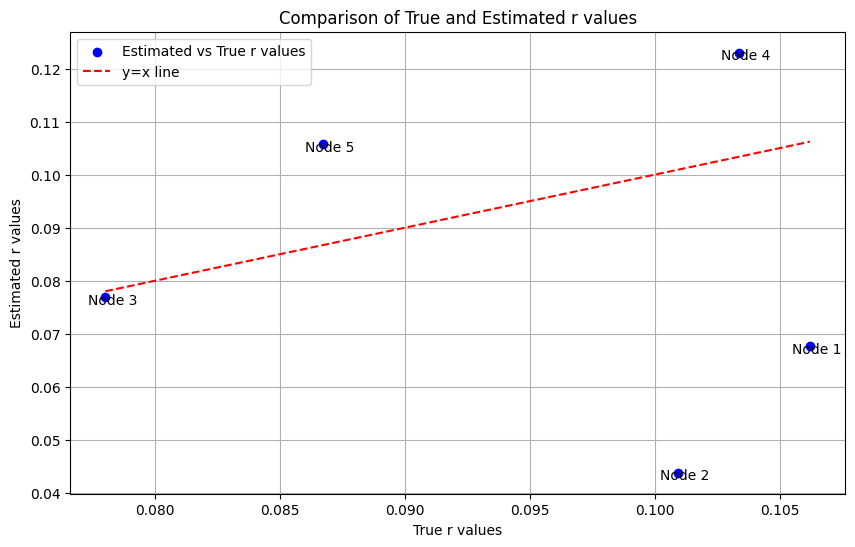

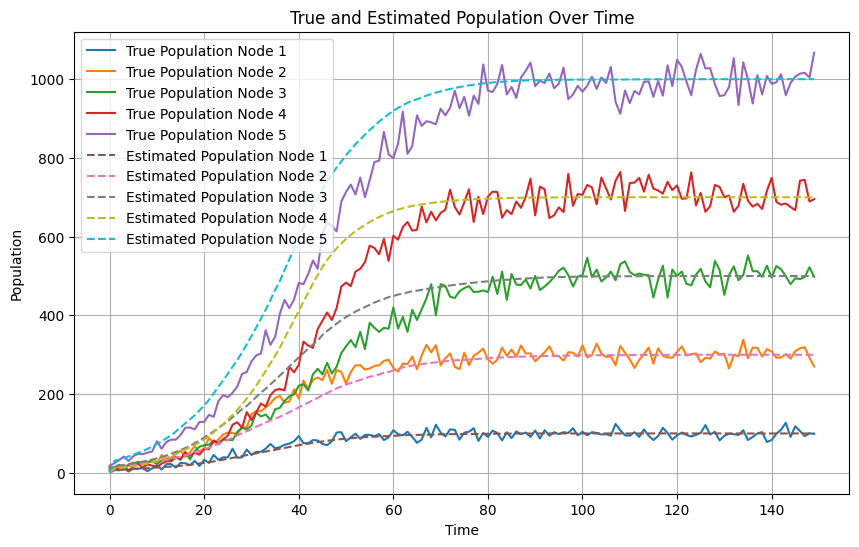

In [51]:
node_labels = [f'Node {i+1}' for i in range(len(r_values))]

"""Plotting r values"""
plt.figure(figsize=(10, 6))
plt.scatter(r_values, estimated_r_values, c='blue', label='Estimated vs True r values')

# Add labels to each point
for i, label in enumerate(node_labels):
    plt.annotate(label, (r_values[i], estimated_r_values[i]), textcoords="offset points", xytext=(5,-5), ha='center')

# Plot the y=x reference line
plt.plot([min(r_values), max(r_values)], [min(r_values), max(r_values)], 'r--', label='y=x line')

# Add labels and title
plt.xlabel('True r values')
plt.ylabel('Estimated r values')
plt.title('Comparison of True and Estimated r values')
plt.legend()
plt.grid(True)
plt.show()


"""Plotting population"""
time_steps = generated_data.shape[1]
num_nodes = generated_data.shape[0]

# Plot the true population over time
plt.figure(figsize=(10, 6))
for i in range(num_nodes):
    plt.plot(range(time_steps), generated_data[i], label=f'True Population Node {i+1}')

# Plot the estimated population over time

for i in range(num_nodes):
    plt.plot(range(time_steps), estimated_populations[i], linestyle='--', label=f'Estimated Population Node {i+1}')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('True and Estimated Population Over Time')
plt.legend()
plt.grid(True)
plt.show()